In [1]:
import numpy as np
import xarray as xr
from pyfunctions import *

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ; sys.path.append("../../") 
from ppe_analysis.analysis import *

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

/glade/u/home/linnia/miniconda3/envs/mlenv/lib/python3.9/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


### Save LHC PxB LAI and GPP

In [4]:
# CLM-PPE
dvs=['TLAI','GPP']
htape='h1'
yr0=2001
yr1=2014
ds=get_exp('transient',dvs=dvs,tape=htape,yy=(yr0,yr1))

In [5]:
da = ds.TLAI.sel(time=slice(str(2003),str(2007)))

In [6]:
lai=amax(da).compute()
lai_pxb = pbmean(lai.drop('pft'),minarea=0)
lai_pxb = lai_pxb.mean(dim='year').compute()

In [7]:
laimean=amean(da).compute()
laimean_pxb = pbmean(laimean.drop('pft'),minarea=0)
laimean_pxb = laimean_pxb.mean(dim='year').compute()

In [9]:
lai_pxb = lai_pxb.rename('TLAI')
lai_pxb.to_netcdf('lai_amax_pxb_2003-2007.nc')
laimean_pxb = laimean_pxb.rename('TLAI')
laimean_pxb.to_netcdf('lai_amean_pxb_2003-2007.nc')

In [ ]:
da = ds.GPP.sel(time=slice(str(2001),str(2010)))
gpp=amean(da).compute()

In [ ]:
gpp_pxb = pbmean(gpp.drop('pft'),minarea=0)
gpp_pxb = gpp_pxb.mean(dim='year').compute()

In [ ]:
gpp_pxb = gpp_pxb.rename('GPP')
gpp_pxb.to_netcdf('gpp_amean_pxb_2001-2010_v2.nc')

### Define PFTxBiome ecoregions

In [51]:
whit=xr.open_dataset('whit/whitkey.nc')
biome_names = whit.biome_name.values
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pft_names=[str(p)[2:-1].strip() for p in pfts.values]

In [14]:
# Define PxB "ecoregions"
# Excluding PFT7 biome 2 & 3 and PFT10 biome 2 & 3 (lots of zeros)
pb_index = {}
pb_index[pft_names[1]] = [2,5,6,7,8]
pb_index[pft_names[2]] = [4,5,6,8,9]
pb_index[pft_names[3]] = [8,9]
pb_index[pft_names[4]] = [1,2,3]
pb_index[pft_names[5]] = [2,3,5,6]
pb_index[pft_names[6]] = [2,3]
pb_index[pft_names[7]] = [5,6,7]
pb_index[pft_names[8]] = [5,6,8]
pb_index[pft_names[9]] = []
pb_index[pft_names[10]] = [6,7]
pb_index[pft_names[11]] = [8,9]
pb_index[pft_names[12]] = [5,6,7,8,9] 
pb_index[pft_names[13]] = [2,3,5,6,7,8]
pb_index[pft_names[14]] = [1,2,3,5,6,7] 
pb_index[pft_names[15]] = [1,2,3,5,6,7,8]
pb_index[pft_names[16]] = [2,3,5,6,7]
np.save('pb_index.npy', pb_index) 

In [2]:
pb_index = np.load('pb_index.npy', allow_pickle=True).item()

In [168]:
bp_index = {}
bp_index[biome_names[1]] = [4,14,15]
bp_index[biome_names[2]] = [1,5,6,13]
bp_index[biome_names[3]] = [4,5,6,13,14,15]
bp_index[biome_names[4]] = [2]
bp_index[biome_names[5]] = [1,2,5,7,8,12,13,14,15]
bp_index[biome_names[6]] = [1,2,5,7,8,10,12,13,14,15]
bp_index[biome_names[7]] = [1,7,10,12,13,14,15]
bp_index[biome_names[8]] = [1,2,3,8,11,12,13,15]
bp_index[biome_names[9]] = [2,3,11,12]
np.save('bp_index.npy', bp_index) 

In [ ]:
# Select PXB that contribute more than 1% to global GPP
ds_h0=get_exp('transient',dvs=['TLAI','GPP'],tape='h0',yy=(2001,2010))
def_gpp = ds_h0.GPP.sel(ens=0)
def_gpp_am = amean(def_gpp).mean(dim='year')
la = get_la()
def_gpp_am_gm = gmean(def_gpp_am,la)

gpp_pxb=xr.open_dataset('gpp_amean_pxb_2001-2010_v2.nc')

GPP_frac = (gpp_pxb.GPP.isel(ens=0))/G

########################
# get land area
f='/glade/work/djk2120/ppe_savs/pbmean/sg_lapxb.nc'
lapxb=xr.open_dataset(f).lapxb
ix=(lapxb.pxb>9)&(lapxb.mean(dim='year').sum(dim='pft')>0)
pxb_la = lapxb.isel(pxb=ix).sum(dim='pft')
pb_la = pxb_la.sel(year=slice(2001,2010)).mean(dim='year').compute()

la = get_la()
global_la = la.sum()
############################

In [1]:
# plot
# unravel pxb
Gfrac = np.empty([17,10])*np.NaN
for p in [1,2,3,4,5,6,7,8,10,11,12,13,14,15]:
    for b in pb_index[pft_names[p]]:  
        pxb = p*10+b
        pxb_la = pb_la.sel(pxb=pxb)
        Gfrac[p,b] = GPP_frac.sel(pxb=pxb)*pxb_la/global_la

df_r2 = pd.DataFrame(Gfrac)
df_r2.index = pft_names[0:17]
df_r2.columns = biome_names

plt.figure(num=None, figsize=(14, 7), dpi=100, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
data = df_r2.transpose().iloc[::-1]
cmap = plt.get_cmap('Spectral', 11)
#custom_cmap_colors = ['grey'] + plt.cm.viridis(np.linspace(0, 1, 11)).tolist()
#custom_cmap = ListedColormap(custom_cmap_colors)

im = ax.imshow(data,cmap=cmap,vmin=0.01,vmax=.3)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(10), labels=data.index)
ax.set_yticklabels(ax.get_yticklabels())
ax.set_xticks(np.arange(17), labels=data.columns,rotation = 90)
plt.title('LAI')
plt.tight_layout()

cbar = plt.colorbar(im)
cbar.set_label("GPP frac")
plt.savefig('./figs/GPP_PXB_contribution_to_Global.png')

NameError: name 'np' is not defined

In [ ]:
# Define PxB "ecoregions"
# Excluding PFT7 biome 2 & 3 and PFT10 biome 2 & 3 (lots of zeros)
pb_priority = {}
pb_priority[pft_names[1]] = [5,6]
pb_priority[pft_names[2]] = [8]
pb_priority[pft_names[3]] = [9]
pb_priority[pft_names[4]] = [1,2]
pb_priority[pft_names[5]] = []
pb_priority[pft_names[6]] = [2]
pb_priority[pft_names[7]] = [5]
pb_priority[pft_names[8]] = []
pb_priority[pft_names[9]] = []
pb_priority[pft_names[10]] = []
pb_priority[pft_names[11]] = [9]
pb_priority[pft_names[12]] = [8,9] 
pb_priority[pft_names[13]] = [2,5,6]
pb_priority[pft_names[14]] = [1,2,3] 
pb_priority[pft_names[15]] = [2,5,6]
pb_priority[pft_names[16]] = []
np.save('pb_priority.npy', pb_priority) 

### Observational LAI data 

In [155]:
f='/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0000.clm2.h1.1985-02-01-00000.nc'
dsg=xr.open_dataset(f)

In [156]:
# SP h1
dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
veg=dsp.pfts1d_itype_veg>0
lai=dsp.TLAI.isel(pft=veg)
latlonp=xr.DataArray(10**6*dsp.pfts1d_jxy+10**3*dsp.pfts1d_ixy+dsp.pfts1d_itype_veg,dims='pft')[veg]
lai['pft']=latlonp

In [157]:
idx=xr.DataArray(10**6 *dsg.pfts1d_jxy+10**3 * dsg.pfts1d_ixy+dsg.pfts1d_itype_veg,dims='pft',name='pft')
good=np.array([i in latlonp for i in idx.values])
flag=(dsg.pfts1d_itype_veg>0)&(good)

In [158]:
laiout=xr.DataArray(np.zeros([12,8574]),dims=['time','pft'],coords={'time': lai.time})
laiout[:,flag]=lai.sel(pft=idx[flag])

In [160]:
SP_amax = amax(laiout)
SP_pxb_amax = pbmean(SP_amax)
SP_pxb_amax = SP_pxb_amax.rename('TLAI')
SP_pxb_amax.to_netcdf('CLM-SP_LAI_pxb_amax_2003-2007.nc')

In [161]:
SP_amean = amean(laiout)
SP_pxb_amean = pbmean(SP_amean)
SP_pxb_amean = SP_pxb_amean.rename('TLAI')
SP_pxb_amean.to_netcdf('CLM-SP_LAI_pxb_amean_2003-2007.nc')

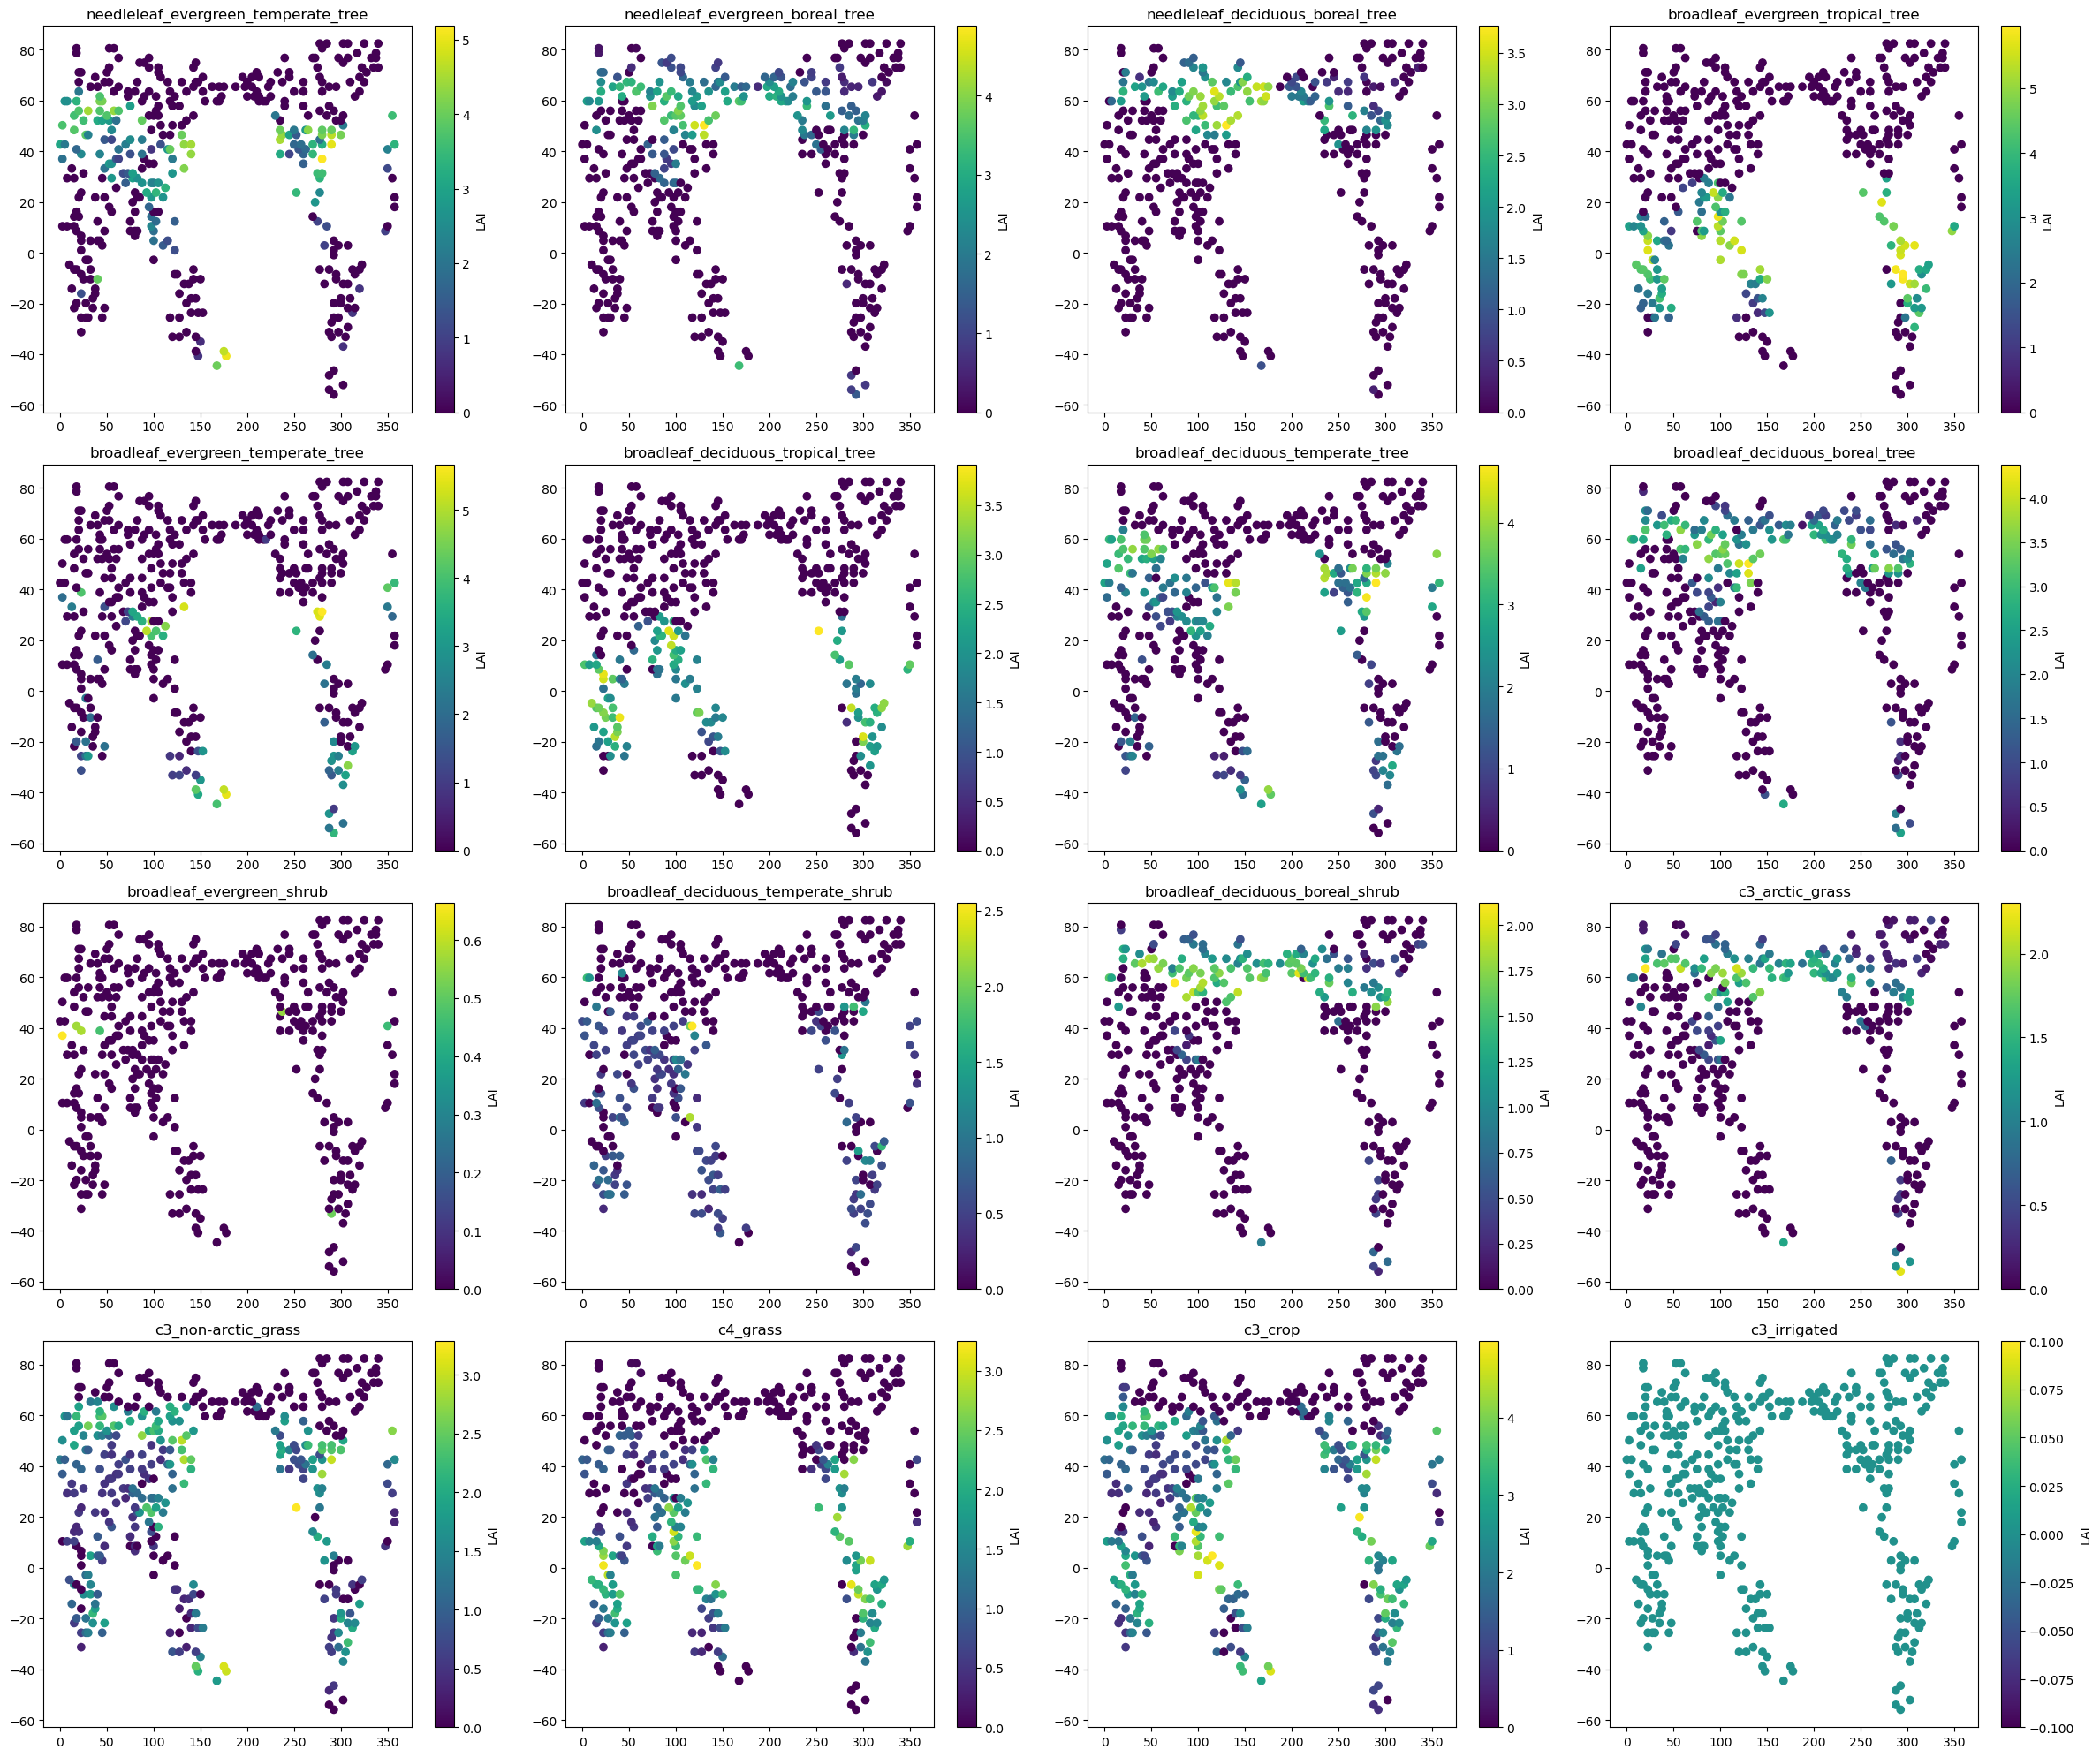

In [108]:
# plot to check
plt.figure(figsize=[24,20])
plt.rcParams.update({'font.size': 10})

pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pft_names=[str(p)[2:-1].strip() for p in pfts.values]

for pft in range(1,17):
    plt.subplot(4,4,pft)
    ix=ds.pfts1d_itype_veg==pft
    plt.scatter(ds.pfts1d_lon[ix],ds.pfts1d_lat[ix],c=SP_amax[:,ix],cmap='viridis')
    plt.title(pft_names[pft])
    plt.colorbar(label='LAI')

plt.tight_layout()
plt.savefig('./figs/CLM-SP_PFT_LAImax.png')

In [146]:
ix=[(dsg.pfts1d_active[i]==1)&(j not in latlonp) for i,j in enumerate(idx.values)]

(array([2.067e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.490e+02]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16.]),
 <BarContainer object of 16 artists>)

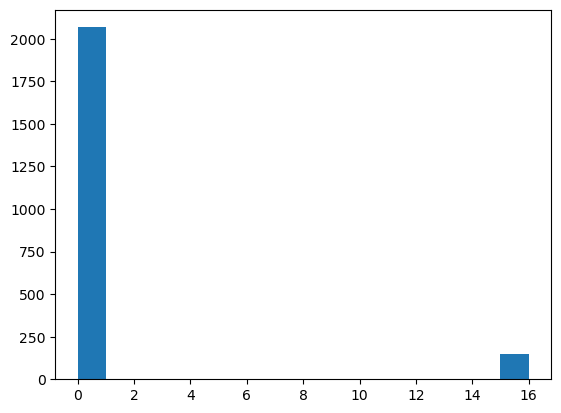

In [154]:
plt.hist(dsg.pfts1d_itype_veg[ix],bins = np.arange(0,17,1))

### LAI Observational Variance

In [5]:
# Satellite products
in_file = '/glade/work/linnia/datasets/GIMMS_LAI4g/GIMMS_LAI4g_V1.2_regridded/GIMMS_LAI4g_V1.2_2deg_1982-2020.nc'
GIMMS_LAI = get_obs_bmean(in_file,2003,2007,'__xarray_dataarray_variable__',max=False)

in_file = '/glade/work/linnia/datasets/GLOBMAP/GlobMapLAIV3_regridded/GlobMapLAIV3_2deg_2001-2020.nc'
GLOBMAP_LAI = get_obs_bmean(in_file,2003,2007,'__xarray_dataarray_variable__',max=False)

In [6]:
# CLM-SP LAI 
ds_sp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h0.2000-02-01-00000.nc')
ds_sp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')

la = get_la()
jvals, ivals = get_sparsegrid() # function in pyfunctions.py
da_sg = ds_sp['TLAI'][:,jvals,ivals]
am = amax(da_sg).mean(dim='year').compute()
SP_LAI = bmean(am,la)

amn = amean(da_sg).mean(dim='year').compute()
SP_LAI_mean = bmean(amn,la)

In [7]:
# AVHRR
in_file = '/glade/work/linnia/ILAMB/ilamb_data/regridded/AVHRR_LAI_regridded.nc'
ds_obs = xr.open_dataset(in_file)
AVHRR_LAI = get_obs_bmean(in_file,2003,2007,'AVHRR_LAI',max=False)

In [165]:
datasets = [GIMMS_LAI, SP_LAI, AVHRR_LAI] # excluding GLOBMAP *it's crazy high*
variance = xr.concat(datasets,dim='clim').var(dim='clim')

out_file = 'LAI_amean_bmean_variance.csv'
variance.to_dataframe(name='TLAI').to_csv(out_file, header=True)

### GPP observational data

In [75]:
# load FLUXCOM-RS-METEO
st_yr = 2001
en_yr = 2010
variable = 'GPP'

in_file = '/glade/work/linnia/datasets/FLUXCOM/FLUXCOM-RS_regridded_2deg_bilinear/FLUXCOM-RS_GPP_FR-ALL_MLM-ALL_2degbilinear_monthly_2001-2015.nc'
FRS_GPP_am_bm = get_obs_bmean(in_file,st_yr,en_yr,variable,max=False)

in_dir = '/glade/work/linnia/datasets/FLUXCOM/FLUXCOM-RS_METEO_regridded_2deg_bilinear/'
in_file = in_dir + 'FLUXCOM-RS_METEO-CERES_GPCP_GPP_FP-ALL_MLM-ALL_2degbilinear_monthly_2001-2014.nc'
FCERES_GPP_am_bm = get_obs_bmean(in_file,st_yr,en_yr,variable,max=False)

in_file = in_dir + 'FLUXCOM-RS_METEO-CRUJRA_v1_GPP_FP-ALL_MLM-ALL_2degbilinear_monthly_1950-2017.nc'
FCRU_GPP_am_bm = get_obs_bmean(in_file,st_yr,en_yr,variable,max=False)

in_file = in_dir + 'FLUXCOM-RS_METEO-ERA5_GPP_FP-ALL_MLM-ALL_2degbilinear_monthly_1979-2018.nc'
FERA_GPP_am_bm = get_obs_bmean(in_file,st_yr,en_yr,variable,max=False)

in_file = in_dir + 'FLUXCOM-RS_METEO-GSWP3_GPP_FP-ALL_MLM-ALL_2degbilinear_monthly_1950-2010.nc'
FGSWP3_GPP_am_bm = get_obs_bmean(in_file,st_yr,en_yr,variable,max=False)

in_file = in_dir + 'FLUXCOM-RS_METEO-WFDEI_GPP_FP-ALL_MLM-ALL_2degbilinear_monthly_1979-2013.nc'
FWFDEI_GPP_am_bm = get_obs_bmean(in_file,st_yr,en_yr,variable,max=False)


In [76]:
out_file = 'FLUXCOM-GSWP3_GPP_amean_bmean_2001-2010.csv'
FGSWP3_GPP_am_bm.to_dataframe(name='GPP').to_csv(out_file, header=True)

In [77]:
datasets = [FRS_GPP_am_bm, FCERES_GPP_am_bm, FCRU_GPP_am_bm,
            FERA_GPP_am_bm, FGSWP3_GPP_am_bm, FWFDEI_GPP_am_bm]
variance = xr.concat(datasets,dim='clim').var(dim='clim')

out_file = 'FLUXCOM_GPP_amean_bmean_variance.csv'
variance.to_dataframe(name='GPP').to_csv(out_file, header=True)

In [78]:
# Absolute range across datasets per Biome
datasets = [FRS_GPP_am_bm, FCERES_GPP_am_bm, FCRU_GPP_am_bm,
            FERA_GPP_am_bm, FGSWP3_GPP_am_bm, FWFDEI_GPP_am_bm]
min_values = xr.concat(datasets, dim='clim').min(dim='clim')
max_values = xr.concat(datasets, dim='clim').max(dim='clim')

df_minmax = pd.DataFrame({'GPPmin':min_values,'GPPmax':max_values},index=FRS_GPP_am_bm.biome_name)
df_minmax.to_csv('FLUXCOM_GPP_minmax_amean_bmean_2001-2010.csv',header=True)

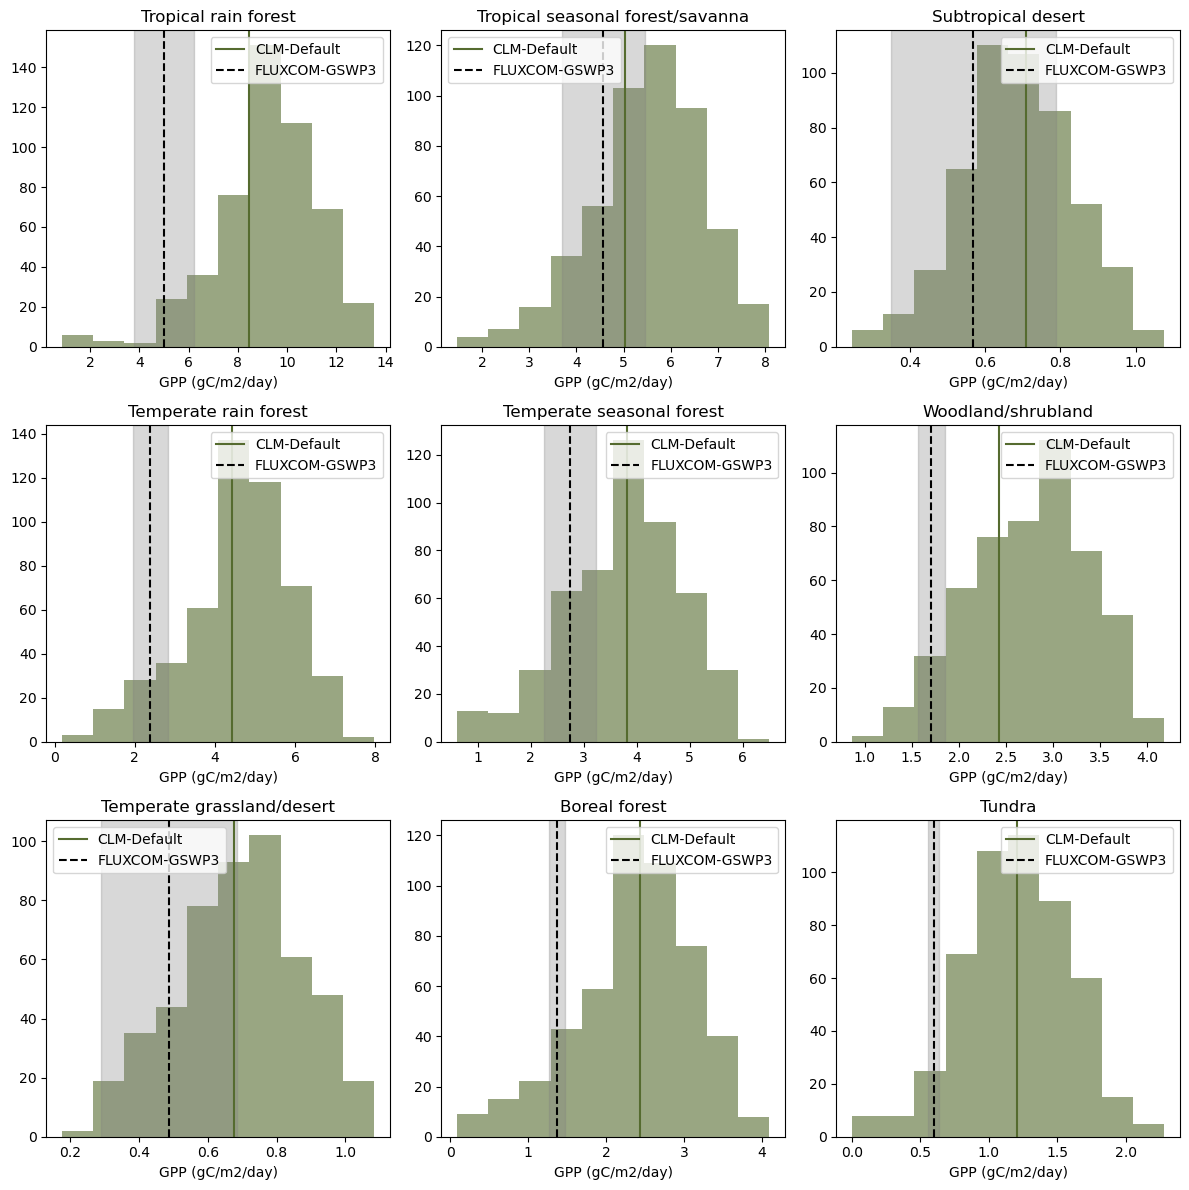

In [83]:
plt.figure(figsize=[12,12])
sd3 = 3*(variance**0.5)
scaler = 60*60*24
for b in range(1,10):
    plt.subplot(3,3,b)
    plt.hist(scaler*gpp_bmean.sel(biome=b),color='darkolivegreen',alpha=0.6)
    plt.axvline(scaler*gpp_bmean.sel(biome=b,ens=0),c='darkolivegreen',label='CLM-Default')
    plt.axvline(FGSWP3_GPP_am_bm.sel(biome=b),c='k',linestyle='--',label='FLUXCOM-GSWP3')
    #plt.axvspan(lai_min_values.sel(biome=b), lai_max_values.sel(biome=b), color='grey', alpha=0.3)
    plt.axvspan(FGSWP3_GPP_am_bm.sel(biome=b)-sd3.sel(biome=b), FGSWP3_GPP_am_bm.sel(biome=b)+sd3.sel(biome=b), color='grey', alpha=0.3)
    plt.xlabel('GPP (gC/m2/day)')
    plt.title(biome_names[b])
    plt.legend()
plt.tight_layout()
plt.savefig('./figs/GPP_biome_hist_obs3SD.png',dpi=100)

### Biome mean error in LAI

In [79]:
# CLM-PPE
dvs=['TLAI','GPP']
htape='h0'
yr0=2003
yr1=2007
ds=get_exp('transient',dvs=dvs,tape=htape,yy=(yr0,yr1))

In [9]:
la = get_la()
lai_bmean = bmean(amax(ds.TLAI),la).mean(dim='year').compute()

In [80]:
la = get_la()
gpp_bmean = bmean(amean(ds.GPP),la).mean(dim='year').compute()

In [84]:
# ovservational range & variance
datasets = [GIMMS_LAI,SP_LAI, AVHRR_LAI]
lai_min_values = xr.concat(datasets, dim='clim').min(dim='clim')
lai_max_values = xr.concat(datasets, dim='clim').max(dim='clim')
variance = xr.concat(datasets,dim='clim').var(dim='clim')

In [85]:
out_file = 'LAI_amean_bmean_variance_GIMMS_SP_AVHRR.csv'
variance.to_dataframe(name='TLAI').to_csv(out_file, header=True)

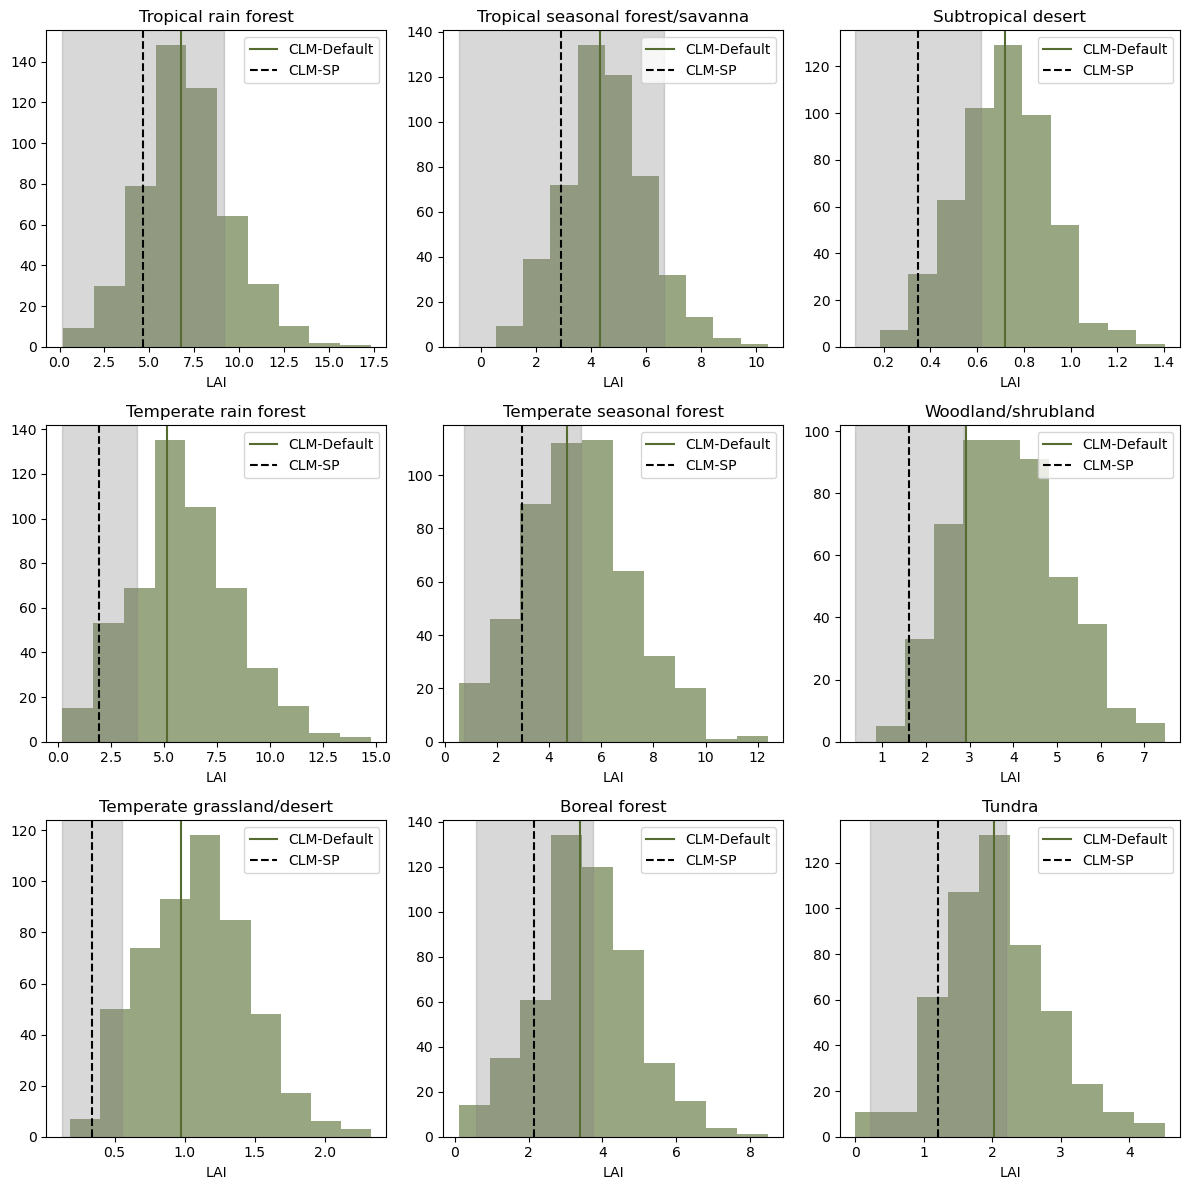

In [74]:
plt.figure(figsize=[12,12])
sd3 = 3*(variance**0.5)
for b in range(1,10):
    plt.subplot(3,3,b)
    plt.hist(lai_bmean.sel(biome=b),color='darkolivegreen',alpha=0.6)
    plt.axvline(lai_bmean.sel(biome=b,ens=0),c='darkolivegreen',label='CLM-Default')
    plt.axvline(SP_LAI.sel(biome=b),c='k',linestyle='--',label='CLM-SP')
    #plt.axvspan(lai_min_values.sel(biome=b), lai_max_values.sel(biome=b), color='grey', alpha=0.3)
    plt.axvspan(SP_LAI.sel(biome=b)-sd3.sel(biome=b), SP_LAI.sel(biome=b)+sd3.sel(biome=b), color='grey', alpha=0.3)
    plt.xlabel('LAI')
    plt.title(biome_names[b])
    plt.legend()
plt.tight_layout()
plt.savefig('./figs/LAI_biome_hist_obs3SD.png',dpi=100)

### Scatter

In [87]:
datasets = [FRS_GPP_am_bm, FCERES_GPP_am_bm, FCRU_GPP_am_bm,
            FERA_GPP_am_bm, FGSWP3_GPP_am_bm, FWFDEI_GPP_am_bm]
gpp_variance = xr.concat(datasets,dim='clim').var(dim='clim')

In [86]:
# ovservational range & variance
datasets = [GIMMS_LAI,SP_LAI, AVHRR_LAI]
lai_variance = xr.concat(datasets,dim='clim').var(dim='clim')

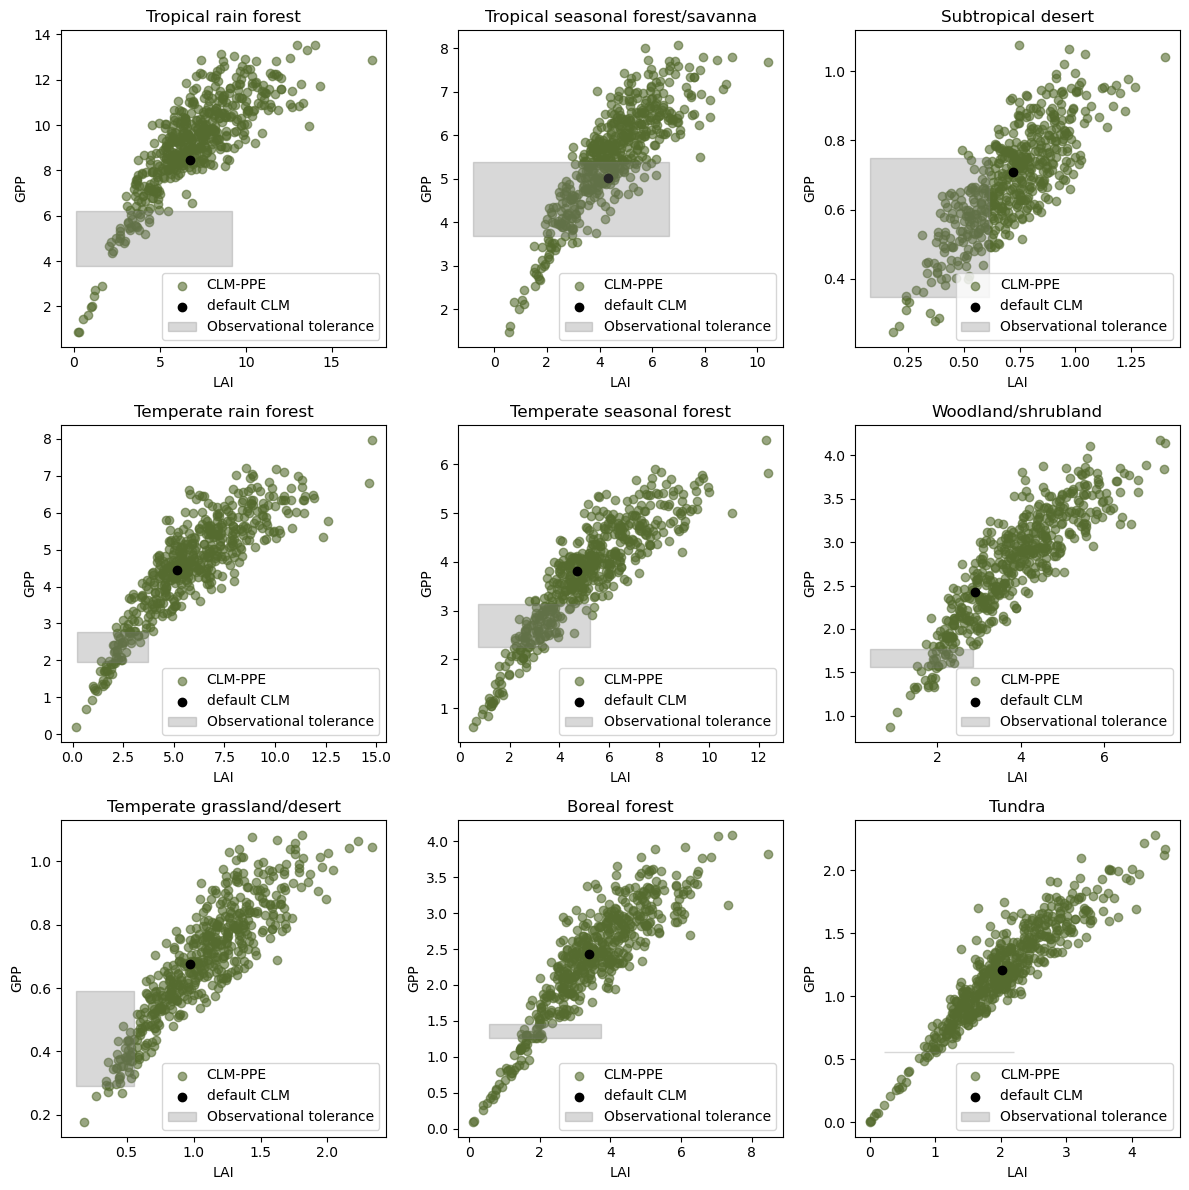

In [103]:
plt.figure(figsize=[12,12])
lai_sd3 = 3*(lai_variance**0.5)
gpp_sd3 = 3*(gpp_variance**0.5)
for b in range(1,10):
    plt.subplot(3,3,b)
    plt.scatter(lai_bmean.sel(biome=b),scaler*gpp_bmean.sel(biome=b),color='darkolivegreen',alpha=0.6,label='CLM-PPE')
    plt.scatter(lai_bmean.sel(biome=b,ens=0),scaler*gpp_bmean.sel(biome=b,ens=0),color='k',alpha=1,label='default CLM')
    #plt.scatter(SP_LAI.sel(biome=b),FGSWP3_GPP_am_bm.sel(biome=b),color='red',label='Observational Target')
    plt.fill_betweenx(np.arange(FGSWP3_GPP_am_bm.sel(biome=b)-gpp_sd3.sel(biome=b),FGSWP3_GPP_am_bm.sel(biome=b)+gpp_sd3.sel(biome=b),.1), SP_LAI.sel(biome=b)-lai_sd3.sel(biome=b), SP_LAI.sel(biome=b)+lai_sd3.sel(biome=b), color='gray', alpha=0.3,label='Observational tolerance')

    plt.xlabel('LAI')
    plt.ylabel('GPP')
    plt.title(biome_names[b])
    plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./figs/LAIvGPP_biome_scatter_obs3SD.png',dpi=100)